# 1. Salaries in data field

##   a) Start with some simple EDA, check summary statistics, info, columns etc

In [29]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv("salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EX,FT,Head of Data,348516,USD,348516,US,0,US,M
1,2025,EX,FT,Head of Data,232344,USD,232344,US,0,US,M
2,2025,SE,FT,Data Scientist,145400,USD,145400,US,0,US,M
3,2025,SE,FT,Data Scientist,81600,USD,81600,US,0,US,M
4,2025,MI,FT,Engineer,160000,USD,160000,US,100,US,M


In [31]:
df.shape

(151445, 11)

In [32]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151445 entries, 0 to 151444
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           151445 non-null  int64 
 1   experience_level    151445 non-null  object
 2   employment_type     151445 non-null  object
 3   job_title           151445 non-null  object
 4   salary              151445 non-null  int64 
 5   salary_currency     151445 non-null  object
 6   salary_in_usd       151445 non-null  int64 
 7   employee_residence  151445 non-null  object
 8   remote_ratio        151445 non-null  int64 
 9   company_location    151445 non-null  object
 10  company_size        151445 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.7+ MB


In [34]:
con = duckdb.connect()
con.register("salaries", df)

##   b) Plot the distribution of the salaries in USD.

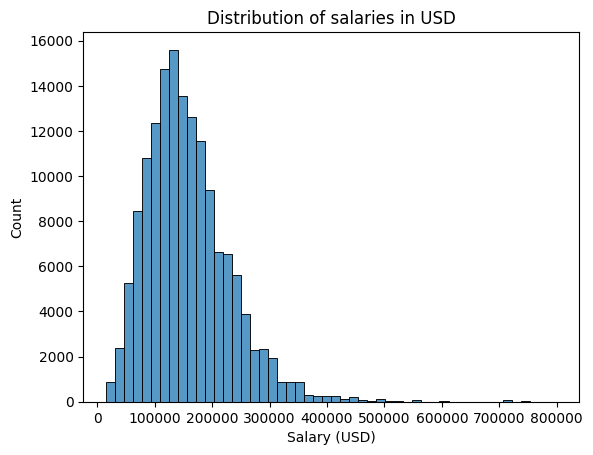

In [45]:
sns.histplot(data=df, x="salary_in_usd", bins=50)

plt.title("Distribution of salaries in USD")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.show()

## c) How many job postings are there for each job title? Take the tenth most common job title and plot a bar chart of the number of job postings for that title.

In [36]:
job_counts = con.execute("""
    SELECT
        job_title,
        COUNT(*) AS postings
    FROM salaries
    GROUP BY job_title
    ORDER BY postings DESC
""").df()

job_counts.head(10)

,job_title,postings
0,Data Scientist,18751
1,Software Engineer,16948
2,Data Engineer,16352
3,Data Analyst,13779
4,Engineer,11004
5,Machine Learning Engineer,8887
6,Manager,7811
7,Analyst,5396
8,Research Scientist,3460
9,Product Manager,2576


In [37]:
tenth_title = job_counts.iloc[9]
tenth_title

job_title    Product Manager
postings                2576
Name: 9, dtype: object

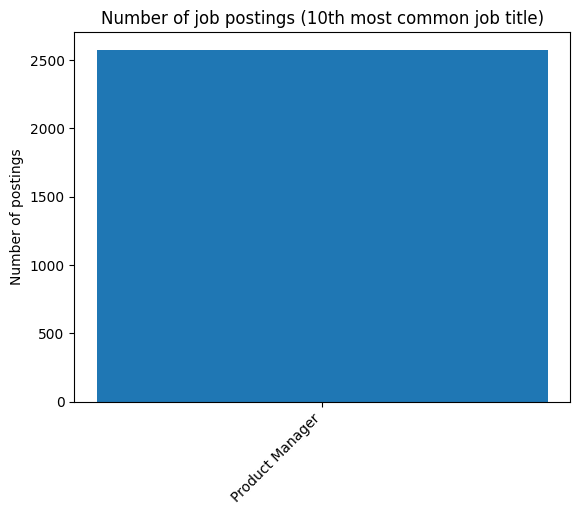

In [38]:
plt.bar(tenth_title["job_title"], tenth_title["postings"])
plt.title("Number of job postings (10th most common job title)")
plt.ylabel("Number of postings")
plt.xticks(rotation=45, ha="right")
plt.show()

### d) Create a dataframe that contains the following columns: job_title, experience_level, median_salary_usd, mean_salary_usd, mean_salary_sek. Sort the dataframe by mean_salary_sek.

In [39]:
salary_stats = con.execute("""
    SELECT
        job_title,
        experience_level,
        MEDIAN(salary_in_usd) AS median_salary_usd,
        AVG(salary_in_usd) AS mean_salary_usd
    FROM salaries
    GROUP BY job_title, experience_level
""").df()

salary_stats.head()

,job_title,experience_level,median_salary_usd,mean_salary_usd
0,Consultant,MI,100806.0,106669.809322
1,Consultant,EN,75780.0,84114.885965
2,Data Integration Specialist,MI,93750.0,93342.948276
3,AI Engineer,MI,148800.0,164852.588580
4,Business Analyst,SE,116900.0,123492.117117


In [40]:
USD_TO_SEK = 10.5
salary_stats["mean_salary_sek"] = (
    salary_stats["mean_salary_usd"] * USD_TO_SEK
)

salary_stats_sorted = salary_stats.sort_values("mean_salary_sek", ascending=False)

salary_stats_sorted.head()


,job_title,experience_level,median_salary_usd,mean_salary_usd,mean_salary_sek
356,AI Architect,MI,800000.0,800000.0,8400000.0
282,Research Team Lead,SE,450000.0,450000.0,4725000.0
550,Principal Data Scientist,EX,416000.0,416000.0,4368000.0
619,Analytics Engineering Manager,SE,399880.0,399880.0,4198740.0
548,Data Science Tech Lead,SE,375000.0,375000.0,3937500.0


## f) Create a column with salary in SEK per month and make the distribution of salaries in SEK per month for all job postings

In [41]:
df["salary_sek_month"] = df["salary_in_usd"] * USD_TO_SEK / 12

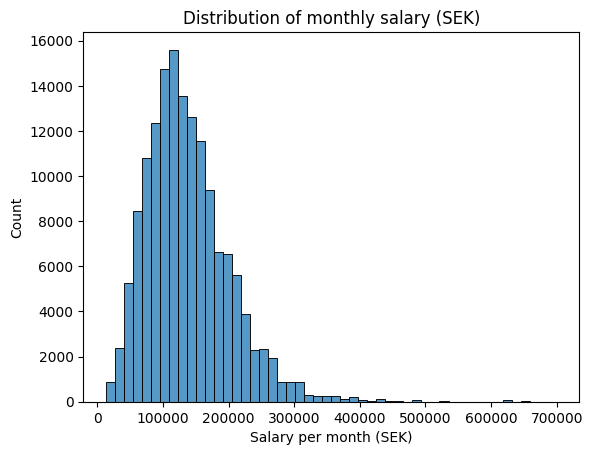

In [46]:
sns.histplot(data=df, x="salary_sek_month", bins=50)

plt.title("Distribution of monthly salary (SEK)")
plt.xlabel("Salary per month (SEK)")
plt.ylabel("Count")
plt.show()

## g) Now create distributions of monthly SEK based on different experience levels, do you see any trends?

In [43]:
df["experience_level"].unique()

array(['EX', 'SE', 'MI', 'EN'], dtype=object)

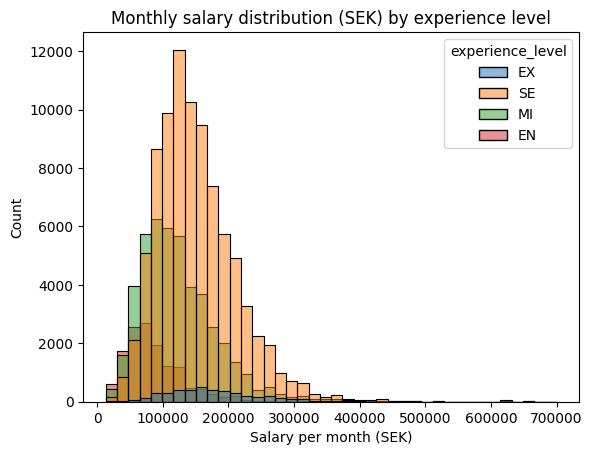

In [44]:
sns.histplot(data=df, x="salary_sek_month", hue="experience_level", bins=40, alpha=0.5)

plt.title("Monthly salary distribution (SEK) by experience level")
plt.xlabel("Salary per month (SEK)")
plt.ylabel("Count")
plt.show()


## h) Find median monthly swedish salary for more common job_titles. Think what common may mean here.

In [48]:
con.execute("""
    SELECT COUNT(*) 
    FROM salaries
    WHERE company_location = 'SE'
""").fetchall()


[(13,)]

In [49]:
con.execute("""
    SELECT job_title, COUNT(*) AS job_postings
    FROM salaries
    WHERE company_location = 'SE'
    GROUP BY job_title
    ORDER BY job_postings DESC
""").df()


,job_title,job_postings
0,Software Engineer,4
1,Data Scientist,2
2,Data Engineer,2
3,Data Analyst,2
4,AI Developer,1
5,Lead AI Engineer,1
6,Big Data Engineer,1


In [ ]:
sweden_common_titles = con.execute("""
    SELECT
        job_title,
        MEDIAN(salary_in_usd) * 10.5 / 12 AS median_salary_sek_month,
        COUNT(*) AS job_postings
    FROM salaries
    WHERE company_location = 'SE'
    GROUP BY job_title
    HAVING COUNT(*) >= 2
    ORDER BY median_salary_sek_month DESC
""").df()

sweden_common_titles

,job_title,median_salary_sek_month,job_postings
0,Software Engineer,140242.8125,4
1,Data Scientist,76262.8125,2
2,Data Engineer,68413.6250,2
3,Data Analyst,41015.6250,2


## i) Join the country_codes.csv to the dataset get the actual country names. Find the median monthly salary in SEK for each country and the number of job postings.

In [53]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'salary_sek_month'],
      dtype='object')

In [60]:
df["company_location"].nunique()


97

In [66]:
countries = pd.read_csv("countries_iso3166b.csv", encoding="latin1")

countries.head()

,iso2,iso3,iso_num,country,country_common
0,AF,AFG,4,Afghanistan,Afghanistan
1,AX,ALA,248,Aland Islands,Aland Islands
2,AL,ALB,8,Albania,Albania
3,DZ,DZA,12,Algeria,Algeria
4,AS,ASM,16,American Samoa,American Samoa


In [70]:
countries = countries.rename(
    columns={
        "iso2": "country_code", 
        "country": "country_name"
})

In [71]:
con.register("countries", countries)

In [ ]:
country_salary_stats = con.execute("""
    SELECT
        c.country_name,
        MEDIAN(s.salary_in_usd) * 10.5 / 12 AS median_salary_sek_month,
        COUNT(*) AS job_postings
    FROM salaries s
    LEFT JOIN countries c
        ON s.company_location = c.country_code
    GROUP BY c.country_name
    ORDER BY median_salary_sek_month DESC
""").df()

country_salary_stats

,country_name,median_salary_sek_month,job_postings
0,Qatar,262500.00,1
1,Congo (the Democratic Republic of the),218750.00,3
2,Venezuela (Bolivarian Republic of),168437.50,2
3,United States of America (the),132300.00,135569
4,Saudi Arabia,131250.00,3
...,...,...,...
92,Hungary,18516.75,10
93,Taiwan (Province of China),16873.50,17
94,Moldova (the Republic of),15750.00,1
95,Ecuador,14000.00,6
